In [5]:
import gzip
import json
from pathlib import Path
from collections import defaultdict
import numpy as np

log_dir = Path("outputs/2025-07-17/14-55-11")          # whatever your save_path was
tag     = "client_grads"               # or "centralized_evaluate", …

file_path = log_dir / f"{tag}.jsonl.gz"
data = []
with gzip.open(file_path, "rt", encoding="utf-8") as fh:
    for raw in fh:                     # one round per iteration
        obj = json.loads(raw)          # dict you stored
        round_nr = obj["round"]
        data.append(obj)


In [6]:
acceleration = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

for round in range(1, len(data)):
    clients = list(data[1].keys())
    clients = clients[1:]
    for client in clients:
        for layer in data[1]['0'].keys():
            history = data[round-1][client][layer]
            print (round, client, layer)
            acceleration[round][client][layer] = np.array(data[round][client][layer]).reshape(-1) - np.array(history).reshape(-1)
                

1 1 conv1.weight
1 1 conv1.bias
1 1 bn1.weight
1 1 bn1.bias
1 1 bn1.running_mean
1 1 bn1.running_var
1 1 bn1.num_batches_tracked
1 1 conv2.weight
1 1 conv2.bias
1 1 bn2.weight
1 1 bn2.bias
1 1 bn2.running_mean
1 1 bn2.running_var
1 1 bn2.num_batches_tracked
1 1 fc1.weight
1 1 fc1.bias
1 1 bn3.weight
1 1 bn3.bias
1 1 bn3.running_mean
1 1 bn3.running_var
1 1 bn3.num_batches_tracked
1 1 fc2.weight
1 1 fc2.bias
1 1 bn4.weight
1 1 bn4.bias
1 1 bn4.running_mean
1 1 bn4.running_var
1 1 bn4.num_batches_tracked
1 1 fc3.weight
1 1 fc3.bias
1 2 conv1.weight
1 2 conv1.bias
1 2 bn1.weight
1 2 bn1.bias
1 2 bn1.running_mean
1 2 bn1.running_var
1 2 bn1.num_batches_tracked
1 2 conv2.weight
1 2 conv2.bias
1 2 bn2.weight
1 2 bn2.bias
1 2 bn2.running_mean
1 2 bn2.running_var
1 2 bn2.num_batches_tracked
1 2 fc1.weight
1 2 fc1.bias
1 2 bn3.weight
1 2 bn3.bias
1 2 bn3.running_mean
1 2 bn3.running_var
1 2 bn3.num_batches_tracked
1 2 fc2.weight
1 2 fc2.bias
1 2 bn4.weight
1 2 bn4.bias
1 2 bn4.running_mean
1 2 

In [96]:
acceleration

defaultdict(<function __main__.<lambda>()>,
            {1: defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'1': defaultdict(float,
                                      {'conv1.weight': array([-3.62868980e-02, -4.25635027e-02, -4.43198974e-02, -3.29943560e-02,
                                              -3.15122288e-02, -5.47628254e-02, -5.40451054e-02, -4.73414436e-02,
                                              -5.22125885e-02, -4.52301726e-02, -7.14020208e-02, -6.25161082e-02,
                                              -4.90492284e-02, -5.61182573e-02, -3.90861519e-02, -6.44234493e-02,
                                              -4.93764728e-02, -3.51581499e-02, -3.09699886e-02, -2.88818032e-02,
                                              -5.32557815e-02, -3.47517580e-02, -2.25692987e-02, -2.15119608e-02,
                                              -3.30598950e-02, -6.95382059e-03, -5.27004153e-03, -8.62093177e-04,
              

In [17]:
# -------------------------------------------------------------
# 0. Imports & helpers
# -------------------------------------------------------------
import gzip, json
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def flatten_layer_dict(layer_dict):
    """Concatenate all layer tensors for one client & round into 1-D vector."""
    # Each layer is already a list/flat 1-D grad; ravel() is cheap protection
    return np.concatenate([np.asarray(v).ravel() for v in layer_dict.values()])

def cosine(u, v):
    """Cosine similarity (returns np.nan when either vector has zero norm)."""
    nu, nv = np.linalg.norm(u), np.linalg.norm(v)
    if nu == 0 or nv == 0:
        return np.nan
    return float(np.dot(u, v) / (nu * nv))
def plot_graphs(n1 = None,n2 = None):
    # -------------------------------------------------------------
    # 1. Load the JSONL-GZ log
    # -------------------------------------------------------------
    # log_dir = Path("outputs/2025-07-17/16-54-31")   # adapt if needed
    log_dir = Path("outputs/big_model_trained")   # adapt if needed
    tag     = "client_grads"
    
    file_path = log_dir / f"{tag}.jsonl.gz"
    round_objs = []                          # index = round_id
    with gzip.open(file_path, "rt", encoding="utf-8") as fh:
        for raw in fh:
            round_objs.append(json.loads(raw))   # dict: {"round": r, ..., client_id: layer_dict, ...}
    
    # How many communication rounds?
    num_rounds = len(round_objs)
    print(f"Loaded {num_rounds} rounds")
    
    # -------------------------------------------------------------
    # 2. Build (client, round)-level metrics
    # -------------------------------------------------------------
    rows_client = []      # one row per client & round
    rows_layer  = []      # one row per client, round, layer
    for r in range(1, num_rounds):               # start at 1 so we have r-1
        prev, curr = round_objs[r-1], round_objs[r]
    
        # Skip the "round" key, keep every client id
        client_ids = [cid for cid in curr.keys() if cid != "round"]
    
        for cid in client_ids:
            g_prev = flatten_layer_dict(prev[cid])
            g_curr = flatten_layer_dict(curr[cid])
    
            acc    = g_curr - g_prev                       # Δg
            rows_client.append(
                dict(round=r,
                     client=cid,
                     mag=np.linalg.norm(acc),
                     cos=cosine(g_curr, g_prev))
            )
    
            # ---------------- layer-level ----------------
            if n1 is None and n2 is None: 
                layers_to_investigate = list(curr[cid].keys())
            elif n1==n2:
                layers_to_investigate = list(curr[cid].keys())[n1]
            else:
                layers_to_investigate = list(curr[cid].keys())[:n1] + list(curr[cid].keys())[n2:]
            
            layers_to_investigate = [layer for layer in layers_to_investigate if 'bn' not in layer]
            
            layers_to_investigate = [layer for layer in layers_to_investigate if 'conv' in layer]
            print ('considering the following layers:', layers_to_investigate)
            for layer_name in layers_to_investigate:
                v_prev = np.asarray(prev[cid][layer_name]).ravel()
                v_curr = np.asarray(curr[cid][layer_name]).ravel()
                acc_L  = v_curr - v_prev
    
                rows_layer.append(
                    dict(round=r,
                         client=cid,
                         layer=layer_name,
                         mag=np.linalg.norm(acc_L),
                         cos=cosine(v_curr, v_prev))
                )
    
    # Wrap in nice DataFrames
    df_client = pd.DataFrame(rows_client)
    df_layer  = pd.DataFrame(rows_layer)
    # -------------------------------------------------------------
    # 3. Scatter plots – highlight client IDs 0‒4
    # -------------------------------------------------------------
    # Helper: which rows belong to clients with integer id ≤ 4?
    def mark_le4(df):
        return df["client"].astype(int) < 4
    
    # -------- Figure 1: per-client & round ---------------------------------------
    plt.figure()
    mask = mark_le4(df_client)
    
    # non-highlighted first, then highlighted on top
    plt.scatter(df_client.loc[~mask, "mag"],
                df_client.loc[~mask, "cos"],
                s=8, alpha=0.25, label="clients > 4")
    
    plt.scatter(df_client.loc[mask, "mag"],
                df_client.loc[mask, "cos"],
                s=15, marker="o", label="clients 0‒4")
    
    plt.title("Acceleration vs. similarity (client-level)")
    plt.xlabel("|Δg|  (Euclidean magnitude)")
    plt.ylabel("cos( gᵣ , gᵣ₋₁ )")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # -------- Figure 2: per-client, per-layer & round ----------------------------
    plt.figure()
    maskL = mark_le4(df_layer)
    
    plt.scatter(df_layer.loc[~maskL, "mag"],
                df_layer.loc[~maskL, "cos"],
                s=6, alpha=0.25, label="clients > 4")
    
    plt.scatter(df_layer.loc[maskL, "mag"],
                df_layer.loc[maskL, "cos"],
                s=10, marker="o", label="clients 0‒4")
    
    plt.title("Acceleration vs. similarity (layer-level)")
    plt.xlabel("|Δg_layer|  (Euclidean magnitude)")
    plt.ylabel("cos( gᵣ , gᵣ₋₁ ) per layer")
    plt.grid(True)
    plt.legend()
    plt.show()

Loaded 10 rounds
considering the following layers: ['conv1.0.weight', 'conv1.1.weight', 'conv1.1.bias', 'conv1.1.running_mean', 'conv1.1.running_var', 'conv1.1.num_batches_tracked', 'conv5.0.weight', 'conv5.1.weight', 'conv5.1.bias', 'conv5.1.running_mean', 'conv5.1.running_var', 'conv5.1.num_batches_tracked']
considering the following layers: ['conv1.0.weight', 'conv1.1.weight', 'conv1.1.bias', 'conv1.1.running_mean', 'conv1.1.running_var', 'conv1.1.num_batches_tracked', 'conv5.0.weight', 'conv5.1.weight', 'conv5.1.bias', 'conv5.1.running_mean', 'conv5.1.running_var', 'conv5.1.num_batches_tracked']
considering the following layers: ['conv1.0.weight', 'conv1.1.weight', 'conv1.1.bias', 'conv1.1.running_mean', 'conv1.1.running_var', 'conv1.1.num_batches_tracked', 'conv5.0.weight', 'conv5.1.weight', 'conv5.1.bias', 'conv5.1.running_mean', 'conv5.1.running_var', 'conv5.1.num_batches_tracked']
considering the following layers: ['conv1.0.weight', 'conv1.1.weight', 'conv1.1.bias', 'conv1.1.ru

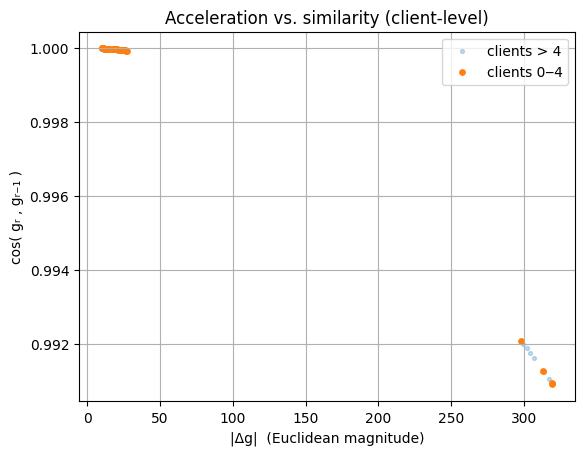

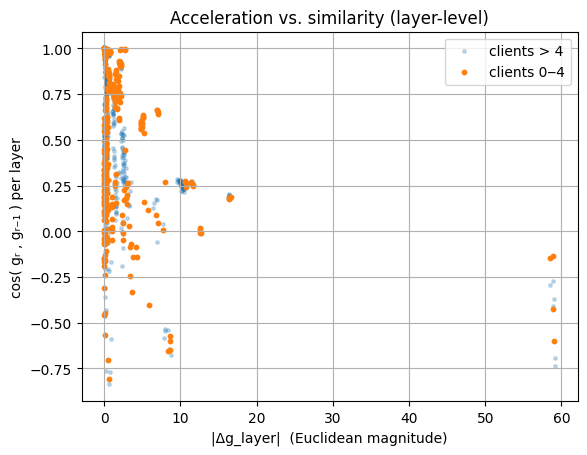

In [18]:
plot_graphs()

In [ ]:
for i in range 